# Predictive Modeling!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


df = pd.read_csv('Dataset .csv')

## Convert 'Yes'/'No' to 1/0 before analysis

In [2]:
yes_no_cols = ['Has Table booking', 'Has Online delivery', 
               'Is delivering now', 'Switch to order menu']

for col in yes_no_cols:
    df[col + ' (encoded)'] = df[col].apply(lambda x: 1 if str(x).strip().lower() == 'yes' else 0)

In [3]:
# Length of restaurant name
df['Restaurant Name Length'] = df['Restaurant Name'].apply(lambda x: len(str(x)))

# Length of address
df['Address Length'] = df['Address'].apply(lambda x: len(str(x)))

print("\nSample of new length features:")
display(df[['Restaurant Name', 'Restaurant Name Length', 'Address', 'Address Length']].head())

# Select only the newly engineered feature columns and display first 5 rows
feature_columns = ['Restaurant Name Length', 
                  'Address Length', 
                  'Has Table booking (encoded)', 
                  'Has Online delivery (encoded)']

# Display the DataFrame with these columns
display(df[feature_columns].head())


Sample of new length features:


,Restaurant Name,Restaurant Name Length,Address,Address Length
0,Le Petit Souffle,16,"Third Floor, Century City Mall, Kalayaan Avenu...",71
1,Izakaya Kikufuji,16,"Little Tokyo, 2277 Chino Roces Avenue, Legaspi...",67
2,Heat - Edsa Shangri-La,22,"Edsa Shangri-La, 1 Garden Way, Ortigas, Mandal...",56
3,Ooma,4,"Third Floor, Mega Fashion Hall, SM Megamall, O...",70
4,Sambo Kojin,11,"Third Floor, Mega Atrium, SM Megamall, Ortigas...",64


,Restaurant Name Length,Address Length,Has Table booking (encoded),Has Online delivery (encoded)
0,16,71,1,0
1,16,67,1,0
2,22,56,1,0
3,4,70,0,0
4,11,64,1,0


## Choosing features & target

In [4]:
# Use only rated restaurants
rated_df = df[df['Aggregate rating'] > 0]

# Features
feature_cols = ['Price range', 
                'Votes', 
                'Has Table booking (encoded)', 
                'Has Online delivery (encoded)',
                'Restaurant Name Length', 
                'Address Length']

X = rated_df[feature_cols]
y = rated_df['Aggregate rating']

## Split data

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")



Training size: 5922, Test size: 1481


## Build & train models

### Linear Regression

In [6]:
lr = LinearRegression()
lr.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


### Decision Tree

In [7]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


### Random Forest

In [8]:
rf = RandomForestRegressor(random_state=42, n_estimators=100)
rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Predict & Evaluate

In [9]:
models = {'Linear Regression': lr, 
          'Decision Tree': dt, 
          'Random Forest': rf}

results = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R²': r2
    }

# Print results neatly
print("\nModel Performance Comparison:")
for name, metrics in results.items():
    print(f"\n{name}:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")


Model Performance Comparison:

Linear Regression:
MAE: 0.3711
MSE: 0.2193
RMSE: 0.4683
R²: 0.2908

Decision Tree:
MAE: 0.3985
MSE: 0.2903
RMSE: 0.5388
R²: 0.0613

Random Forest:
MAE: 0.3016
MSE: 0.1589
RMSE: 0.3987
R²: 0.4861


## Plot: Predicted vs Actual

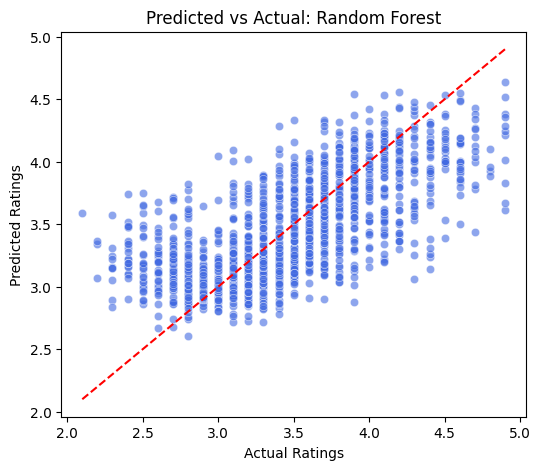

In [10]:
plt.figure(figsize=(6,5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='royalblue')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title(f'Predicted vs Actual: {name}')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

## Cross-validation (example with Random Forest)

In [11]:
rf = RandomForestRegressor(random_state=42, n_estimators=100)
cv_scores = cross_val_score(rf, X, y, cv=5, scoring='r2')
print(f"\nRandom Forest 5-fold CV R² mean: {cv_scores.mean():.4f}, std: {cv_scores.std():.4f}")


Random Forest 5-fold CV R² mean: 0.3559, std: 0.0656


## Hyperparameter tuning for Random Forest

In [12]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
}
grid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, 
                    cv=3, scoring='r2', n_jobs=-1)
grid.fit(X_train, y_train)

print(f"\nBest Random Forest Params: {grid.best_params_}")
print(f"Best CV R² Score: {grid.best_score_:.4f}")


Best Random Forest Params: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}
Best CV R² Score: 0.4829


## Predict on test set with best estimator

In [13]:
best_rf = grid.best_estimator_
y_pred_best = best_rf.predict(X_test)

## Final Evaluation

In [14]:
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"\nBest Random Forest Test MAE: {mae_best:.4f}")
print(f"Best Random Forest Test R²: {r2_best:.4f}")


Best Random Forest Test MAE: 0.2821
Best Random Forest Test R²: 0.5315


## Final plot: predicted vs actual for best RandomForest

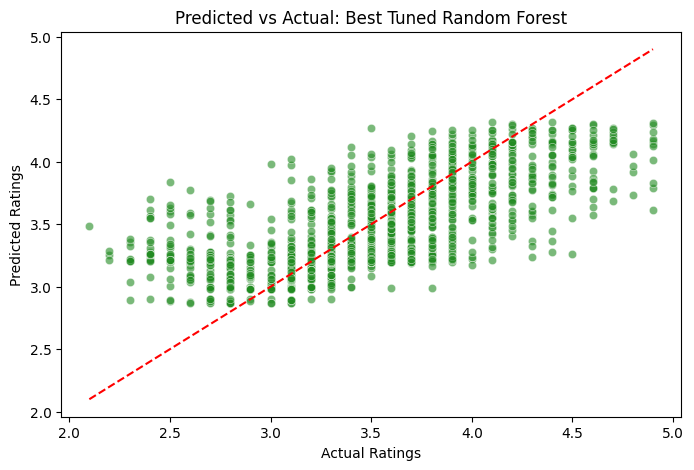

In [15]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_test, y=y_pred_best, alpha=0.6, color='forestgreen')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Predicted vs Actual: Best Tuned Random Forest')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()